In [191]:
import os
import cv2
import pytesseract

# # Get the current working directory and image path
project_dir = os.getcwd()

# Get the current working directory and move one directory up
# project_dir = os.path.dirname(os.getcwd())

# Construct the image path from the project directory
image_path = os.path.join(project_dir, "data_unique", "Original_2.png")

# Load the image
img = cv2.imread(image_path)

# Preprocess the image (if necessary)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply thresholding to make the image binary
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Configure Tesseract to recognize digits only and output symbol-level data
custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789'

# Perform OCR with detailed data output at the symbol level
data = pytesseract.image_to_data(thresh, config=custom_config, output_type=pytesseract.Output.DICT)

# Extract character-level details
recognized_chars = []

n_boxes = len(data['text'])
for i in range(n_boxes):
    text = data['text'][i].strip()
    if text.isdigit():
        recognized_chars.append(text)
# Print the recognized digits
print("Recognized Digits:")
for char in recognized_chars:
    print(f"Number: {char}")


Recognized Digits:
Number: 144123


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw, ImageFont

def generate_plate_number():
    return " ".join([str(random.randint(0, 9)) for _ in range(6)])

def create_license_plate():
    plate_number = generate_plate_number()
    width, height = 400, 100
    background_color = (255, 202, 17)
    text_color = (0, 0, 0)
    text_size = 82

    image = Image.new("RGB", (width, height), background_color)
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("bahnschrift.ttf", text_size)
    except IOError:
        font = ImageFont.load_default()
    text_bbox = draw.textbbox((0, 0), plate_number, font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    text_x = (width - text_width) // 2 - text_bbox[0]
    text_y = (height - text_height) // 2 - text_bbox[1]
    draw.text((text_x, text_y), plate_number, fill=text_color, font=font)

    new_width, new_height = int(width * 1.5), int(height * 2)
    new_image = Image.new("RGB", (new_width, new_height), (0, 0, 0))
    x1, y1 = (new_width - width) // 2, (new_height - height) // 2
    corners = [(x1, y1), (x1 + width, y1), (x1 + width, y1 + height), (x1, y1 + height)]
    new_image.paste(image, (x1, y1))

    return new_image, corners

def calculate_center(points):
    return np.mean(points[:, 0]), np.mean(points[:, 1])

def warp_image(image, src_points, alpha, beta, f=400):
    alpha_rad, beta_rad = np.deg2rad(alpha), np.deg2rad(beta)
    R_y = np.array([[np.cos(alpha_rad), 0, np.sin(alpha_rad)], [0, 1, 0], [-np.sin(alpha_rad), 0, np.cos(alpha_rad)]])
    R_x = np.array([[1, 0, 0], [0, np.cos(beta_rad), -np.sin(beta_rad)], [0, np.sin(beta_rad), np.cos(beta_rad)]])
    R = np.dot(R_y, R_x)
    center = calculate_center(np.array(src_points))
    dst_points = []
    for point in src_points:
        x, y = point[0] - center[0], point[1] - center[1]
        vec = np.dot(R, np.array([x, y, 0]))
        x_proj = center[0] + f * (vec[0] / (f + vec[2]))
        y_proj = center[1] + f * (vec[1] / (f + vec[2]))
        dst_points.append([x_proj, y_proj])
    M = cv2.getPerspectiveTransform(np.float32(src_points), np.float32(dst_points))
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LANCZOS4), dst_points

def add_fine_grain_noise(image, dst_points, stddev=10, alpha=0.4, beta=0.6):
    # Create a mask based on the destination points
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.int32(dst_points)], 255)

    # Convert image to YCrCb color space
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb_image)

    # Generate Gaussian noise
    noise = np.random.normal(0, stddev, Y.shape).astype(np.float32)

    # Scale noise: minimal in dark areas, more in bright areas
    noise_scaled = noise * (alpha + beta * (Y / 255.0))

    # Apply scaled noise only in the masked area
    Y_noisy = np.clip(Y + np.where(mask == 255, noise_scaled, 0), 0, 255).astype(np.uint8)

    # Merge back the noisy Y channel with the original Cr and Cb channels
    noisy_ycrcb_image = cv2.merge([Y_noisy, Cr, Cb])
    noisy_bgr_image = cv2.cvtColor(noisy_ycrcb_image, cv2.COLOR_YCrCb2BGR)

    return noisy_bgr_image

def dewarp_image(image, src_points, dst_points):
    M_inv = cv2.getPerspectiveTransform(np.float32(dst_points), np.float32(src_points))
    return cv2.warpPerspective(image, M_inv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LANCZOS4)

def crop_to_original_size(image, width=400, height=100):
    h, w = image.shape[:2]
    x1, y1 = (w - width) // 2, (h - height) // 2
    return image[y1:y1+height, x1:x1+width]



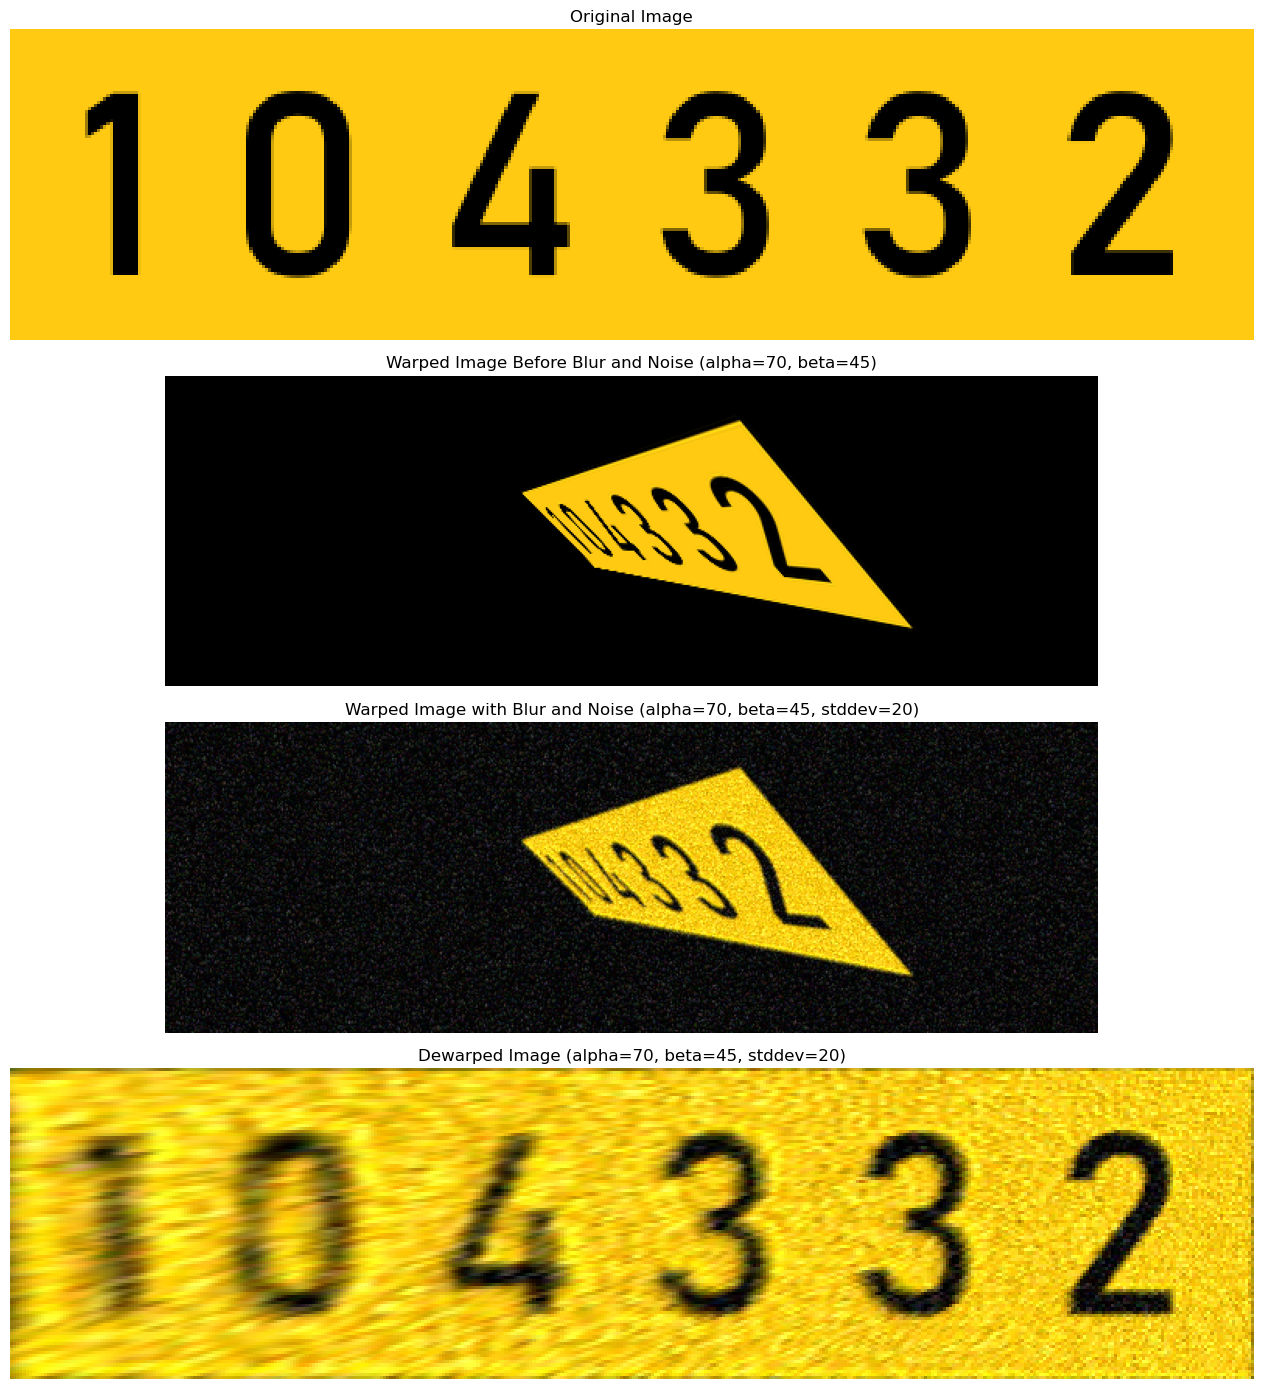

In [2]:
random.seed(42)
np.random.seed(42)

def simulate_luminance_chroma_noise_with_artifacts(image, lum_std=20, chroma_std=10, mosaic_block_size=8):
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    # Generate Gaussian noise for each channel
    lum_noise = np.random.normal(0, lum_std, y.shape).astype(np.float32)
    cr_noise = np.random.normal(0, chroma_std, cr.shape).astype(np.float32)
    cb_noise = np.random.normal(0, chroma_std, cb.shape).astype(np.float32)

    # Add noise and clip values
    y_noisy = np.clip(y.astype(np.float32) + lum_noise, 0, 255).astype(np.uint8)
    cr_noisy = np.clip(cr.astype(np.float32) + cr_noise, 0, 255).astype(np.uint8)
    cb_noisy = np.clip(cb.astype(np.float32) + cb_noise, 0, 255).astype(np.uint8)

    # Merge the noisy YCrCb channels
    ycrcb_noisy = cv2.merge([y_noisy, cr_noisy, cb_noisy])
    noisy_bgr = cv2.cvtColor(ycrcb_noisy, cv2.COLOR_YCrCb2BGR)

    kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    double_edges = cv2.filter2D(noisy_bgr, -1, kernel)
    noisy_bgr = cv2.addWeighted(noisy_bgr, 1, double_edges, 0.2, 0)

    # Add mosaic noise (pixelation effect)
    h, w = noisy_bgr.shape[:2]
    small_h, small_w = h // mosaic_block_size, w // mosaic_block_size
    mosaic = cv2.resize(noisy_bgr, (small_w, small_h), interpolation=cv2.INTER_LINEAR)
    noisy_bgr = cv2.resize(mosaic, (w, h), interpolation=cv2.INTER_NEAREST)

    return noisy_bgr

plate_image, src_points = create_license_plate()
plate_image = cv2.cvtColor(np.array(plate_image), cv2.COLOR_RGB2BGR)
alpha, beta, f = 70, 45, 400

# Warp the image
warped_image, dst_points = warp_image(plate_image, src_points, alpha, beta, f)
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Apply Gaussian blur BEFORE adding noise
blur_kernel_size = (3, 3)  # Adjust kernel size for stronger/weaker blur
blurred_warped_image = cv2.GaussianBlur(warped_image, blur_kernel_size, sigmaX=1, sigmaY=1)

# Add fine-grained luminance noise AFTER blurring
stddev = 20

# noisy_warped_image_bgr = add_fine_grain_noise(blurred_warped_image, dst_points, stddev=stddev, alpha=0.4, beta=0.6)

noisy_warped_image_bgr = simulate_luminance_chroma_noise_with_artifacts(
    blurred_warped_image, lum_std=stddev, chroma_std=stddev/4, mosaic_block_size=1
)

noisy_warped_image_rgb = cv2.cvtColor(noisy_warped_image_bgr, cv2.COLOR_BGR2RGB)

# Dewarp the image
dewarped_image = dewarp_image(cv2.cvtColor(noisy_warped_image_rgb, cv2.COLOR_RGB2BGR), src_points, dst_points)
dewarped_cropped = crop_to_original_size(cv2.cvtColor(dewarped_image, cv2.COLOR_BGR2RGB))

# Plot results
fig, axes = plt.subplots(4, 1, figsize=(18, 14))

# Original Image (Cropped)
cropped_original = crop_to_original_size(plate_image)
axes[0].imshow(cv2.cvtColor(cropped_original, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title('Original Image')

# Warped Image Before Noise (Extended)
axes[1].imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title(f'Warped Image Before Blur and Noise (alpha={alpha}, beta={beta})')

# Warped Image With Blur and Noise (Extended)
axes[2].imshow(noisy_warped_image_rgb)
axes[2].axis('off')
axes[2].set_title(f'Warped Image with Blur and Noise (alpha={alpha}, beta={beta}, stddev={stddev})')

# Dewarped Image (Cropped)
axes[3].imshow(dewarped_cropped)
axes[3].axis('off')
axes[3].set_title(f'Dewarped Image (alpha={alpha}, beta={beta}, stddev={stddev})')

plt.tight_layout()
plt.show()



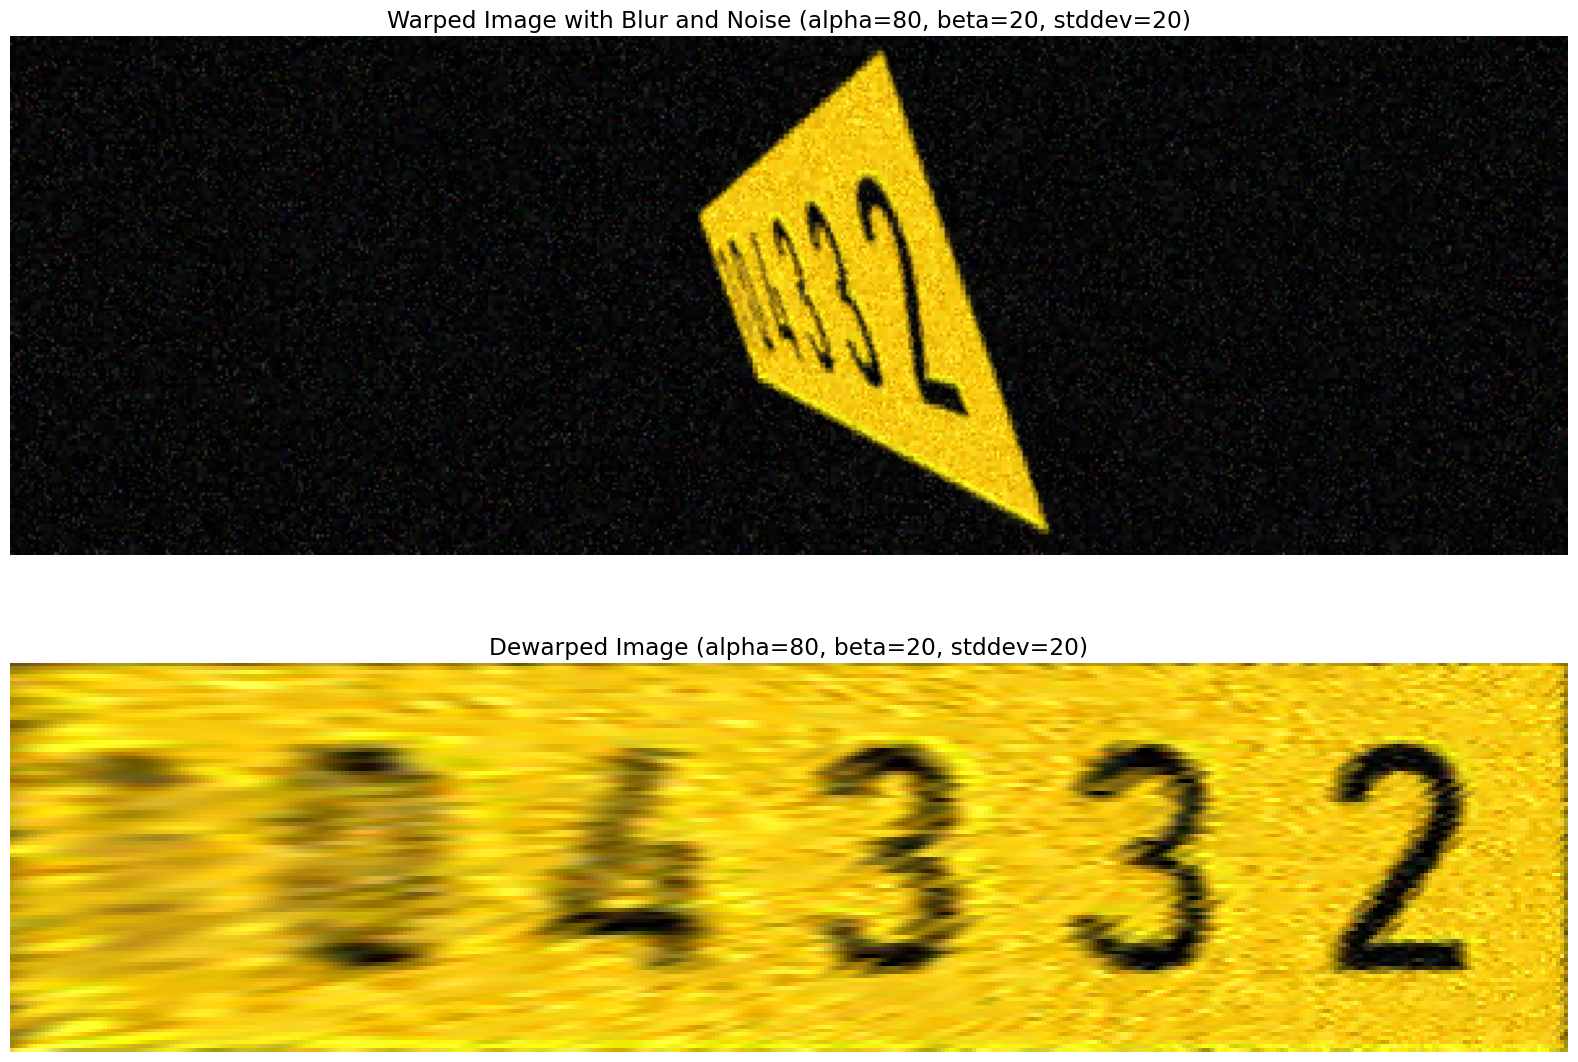

In [20]:
# Double edge effect in Y direction

random.seed(42)
np.random.seed(42)

def simulate_luminance_chroma_noise_with_artifacts(image, lum_std=20, chroma_std=10):
    """
    Simulate consistent double edges, luminance/chroma noise, and mosaic noise applied at the end with random chance per tile.

    Parameters:
        image (ndarray): Input image in BGR format.
        lum_std (int): Standard deviation for luminance noise.
        chroma_std (int): Standard deviation for chroma noise.

    Returns:
        ndarray: Image with added noise and artifacts.
    """
    # Apply consistent double-edge effect
    kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    double_edges = cv2.filter2D(image, -1, kernel)
    image = cv2.addWeighted(image, 1, double_edges, 0.3, 0)

    # Add luminance and chroma noise
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    lum_noise = np.random.normal(0, lum_std, y.shape).astype(np.float32)
    cr_noise = np.random.normal(0, chroma_std, cr.shape).astype(np.float32)
    cb_noise = np.random.normal(0, chroma_std, cb.shape).astype(np.float32)

    y_noisy = np.clip(y.astype(np.float32) + lum_noise, 0, 255).astype(np.uint8)
    cr_noisy = np.clip(cr.astype(np.float32) + cr_noise, 0, 255).astype(np.uint8)
    cb_noisy = np.clip(cb.astype(np.float32) + cb_noise, 0, 255).astype(np.uint8)

    # Merge and convert back to BGR
    ycrcb_noisy = cv2.merge([y_noisy, cr_noisy, cb_noisy])
    noisy_bgr = cv2.cvtColor(ycrcb_noisy, cv2.COLOR_YCrCb2BGR)

    # Apply mosaic noise with 25% probability on tiles of size 2 or 4
    h, w = noisy_bgr.shape[:2]
    mosaic_image = noisy_bgr.copy()

    tile_size = 4
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            if random.random() < 0.35:
                tile_h = min(tile_size, h - y)
                tile_w = min(tile_size, w - x)

                # Apply mosaic effect with fixed block size 2
                tile = mosaic_image[y:y+tile_h, x:x+tile_w]
                small_h, small_w = max(1, tile_h // 2), max(1, tile_w // 2)
                mosaic_tile = cv2.resize(tile, (small_w, small_h), interpolation=cv2.INTER_LINEAR)
                mosaic_tile = cv2.resize(mosaic_tile, (tile_w, tile_h), interpolation=cv2.INTER_NEAREST)

                # Replace tile in the image
                mosaic_image[y:y+tile_h, x:x+tile_w] = mosaic_tile

    return mosaic_image


plate_image, src_points = create_license_plate()
plate_image = cv2.cvtColor(np.array(plate_image), cv2.COLOR_RGB2BGR)
alpha, beta, f = 80, 20, 400

# Warp the image
warped_image, dst_points = warp_image(plate_image, src_points, alpha, beta, f)
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Apply Gaussian blur BEFORE adding noise
blur_kernel_size = (3, 3)  # Adjust kernel size for stronger/weaker blur
blurred_warped_image = cv2.GaussianBlur(warped_image, blur_kernel_size, sigmaX=1, sigmaY=1)

# Add fine-grained luminance noise AFTER blurring
stddev = 20

noisy_warped_image_bgr = simulate_luminance_chroma_noise_with_artifacts(blurred_warped_image, lum_std=stddev, chroma_std=stddev/4)

noisy_warped_image_rgb = cv2.cvtColor(noisy_warped_image_bgr, cv2.COLOR_BGR2RGB)

# Dewarp the image
dewarped_image = dewarp_image(cv2.cvtColor(noisy_warped_image_rgb, cv2.COLOR_RGB2BGR), src_points, dst_points)
dewarped_cropped = crop_to_original_size(cv2.cvtColor(dewarped_image, cv2.COLOR_BGR2RGB))

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Warped Image With Blur and Noise (Extended)
axes[0].imshow(noisy_warped_image_rgb)
axes[0].axis('off')
axes[0].set_title(f'Warped Image with Blur and Noise (alpha={alpha}, beta={beta}, stddev={stddev})')

# Dewarped Image (Cropped)
axes[1].imshow(dewarped_cropped)
axes[1].axis('off')
axes[1].set_title(f'Dewarped Image (alpha={alpha}, beta={beta}, stddev={stddev})')

plt.rcParams.update({'font.size': 14})

plt.tight_layout()
plt.show()



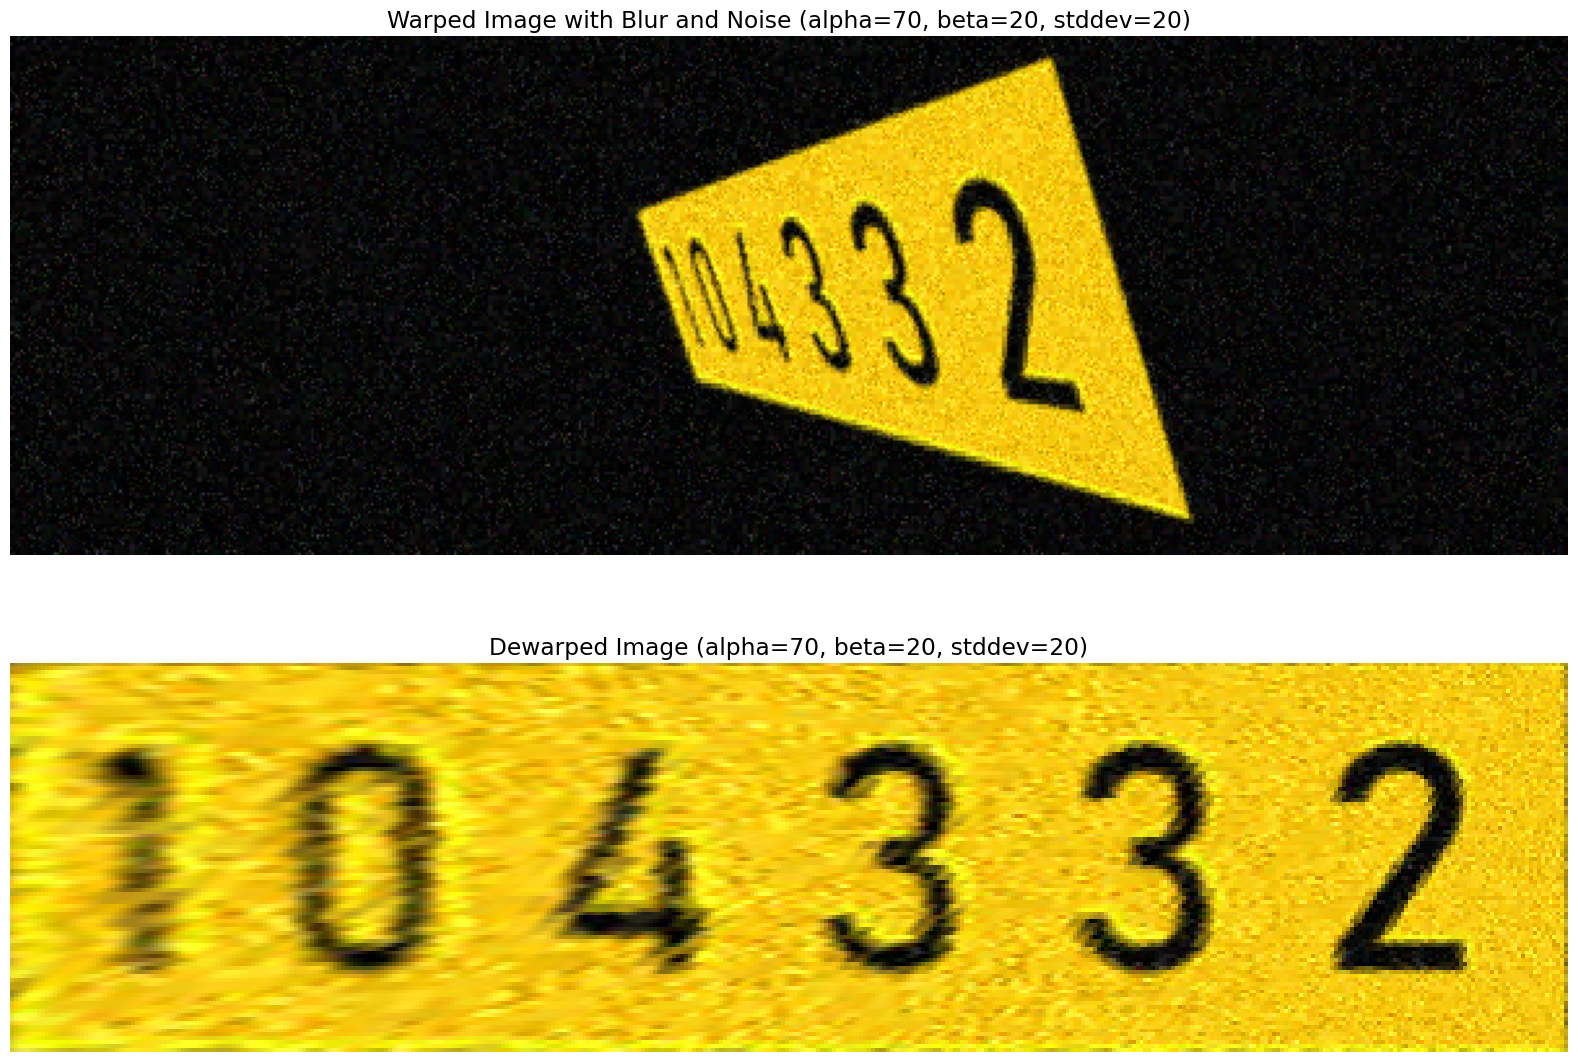

In [4]:
# Double edge effect in Y and X direction

random.seed(42)
np.random.seed(42)

def simulate_luminance_chroma_noise_with_artifacts(image, lum_std=20, chroma_std=10):
    """
    Simulate consistent double edges, luminance/chroma noise, and mosaic noise applied at the end with random chance per tile.

    Parameters:
        image (ndarray): Input image in BGR format.
        lum_std (int): Standard deviation for luminance noise.
        chroma_std (int): Standard deviation for chroma noise.

    Returns:
        ndarray: Image with added noise and artifacts.
    """
    # Apply consistent double-edge effect
    kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    double_edges = cv2.filter2D(image, -1, kernel)
    image = cv2.addWeighted(image, 1, double_edges, 0.3, 0)
    
    kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    double_edges = cv2.filter2D(image, -1, kernel)
    image = cv2.addWeighted(image, 1, double_edges, 0.1, 0)

    # Add luminance and chroma noise
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    lum_noise = np.random.normal(0, lum_std, y.shape).astype(np.float32)
    cr_noise = np.random.normal(0, chroma_std, cr.shape).astype(np.float32)
    cb_noise = np.random.normal(0, chroma_std, cb.shape).astype(np.float32)

    y_noisy = np.clip(y.astype(np.float32) + lum_noise, 0, 255).astype(np.uint8)
    cr_noisy = np.clip(cr.astype(np.float32) + cr_noise, 0, 255).astype(np.uint8)
    cb_noisy = np.clip(cb.astype(np.float32) + cb_noise, 0, 255).astype(np.uint8)

    # Merge and convert back to BGR
    ycrcb_noisy = cv2.merge([y_noisy, cr_noisy, cb_noisy])
    noisy_bgr = cv2.cvtColor(ycrcb_noisy, cv2.COLOR_YCrCb2BGR)

    # Apply mosaic noise with 25% probability on tiles of size 2 or 4
    h, w = noisy_bgr.shape[:2]
    mosaic_image = noisy_bgr.copy()

    tile_size = 4
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            if random.random() < 0.35:
                tile_h = min(tile_size, h - y)
                tile_w = min(tile_size, w - x)

                # Apply mosaic effect with fixed block size 2
                tile = mosaic_image[y:y+tile_h, x:x+tile_w]
                small_h, small_w = max(1, tile_h // 2), max(1, tile_w // 2)
                mosaic_tile = cv2.resize(tile, (small_w, small_h), interpolation=cv2.INTER_LINEAR)
                mosaic_tile = cv2.resize(mosaic_tile, (tile_w, tile_h), interpolation=cv2.INTER_NEAREST)

                # Replace tile in the image
                mosaic_image[y:y+tile_h, x:x+tile_w] = mosaic_tile

    return mosaic_image



plate_image, src_points = create_license_plate()
plate_image = cv2.cvtColor(np.array(plate_image), cv2.COLOR_RGB2BGR)
alpha, beta, f = 70, 20, 400

# Warp the image
warped_image, dst_points = warp_image(plate_image, src_points, alpha, beta, f)
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Apply Gaussian blur BEFORE adding noise
blur_kernel_size = (3, 3)  # Adjust kernel size for stronger/weaker blur
blurred_warped_image = cv2.GaussianBlur(warped_image, blur_kernel_size, sigmaX=1, sigmaY=1)

# Add fine-grained luminance noise AFTER blurring
stddev = 20

noisy_warped_image_bgr = simulate_luminance_chroma_noise_with_artifacts(blurred_warped_image, lum_std=stddev, chroma_std=stddev/4)

noisy_warped_image_rgb = cv2.cvtColor(noisy_warped_image_bgr, cv2.COLOR_BGR2RGB)

# Dewarp the image
dewarped_image = dewarp_image(cv2.cvtColor(noisy_warped_image_rgb, cv2.COLOR_RGB2BGR), src_points, dst_points)
dewarped_cropped = crop_to_original_size(cv2.cvtColor(dewarped_image, cv2.COLOR_BGR2RGB))

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Warped Image With Blur and Noise (Extended)
axes[0].imshow(noisy_warped_image_rgb)
axes[0].axis('off')
axes[0].set_title(f'Warped Image with Blur and Noise (alpha={alpha}, beta={beta}, stddev={stddev})')

# Dewarped Image (Cropped)
axes[1].imshow(dewarped_cropped)
axes[1].axis('off')
axes[1].set_title(f'Dewarped Image (alpha={alpha}, beta={beta}, stddev={stddev})')

plt.rcParams.update({'font.size': 14})

plt.tight_layout()
plt.show()



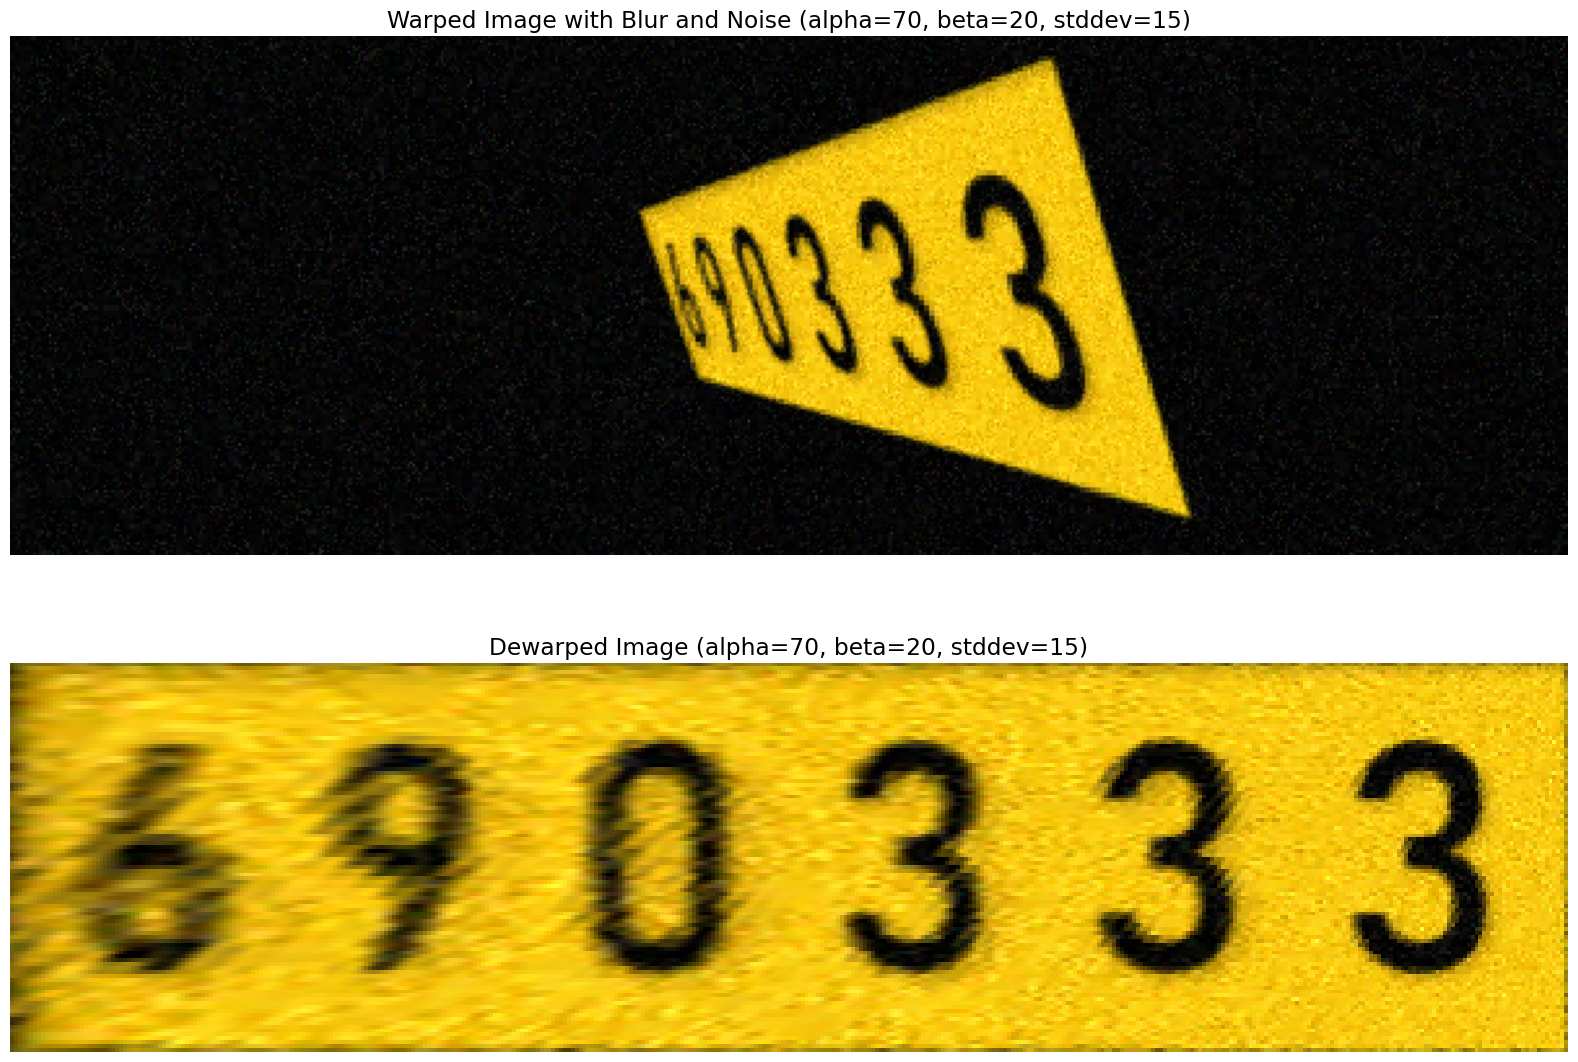

In [5]:
#  Simulate a volumetric, shadow-like effect on the digits, add luminance/chroma noise


#random.seed(42)
#np.random.seed(42)

import cv2
import numpy as np
import random

def simulate_luminance_chroma_noise_with_artifacts(image, lum_std=20, chroma_std=10, shadow_offset=(3, 3), shadow_intensity=0.2):
    """
    Simulate a volumetric, shadow-like effect on the digits, add luminance/chroma noise,
    and then apply mosaic noise at the end with 25% chance per tile.

    Parameters:
        image (ndarray): Input image in BGR format.
        lum_std (int): Standard deviation for luminance noise.
        chroma_std (int): Standard deviation for chroma noise.
        shadow_offset (tuple): Pixel offset for the shadow (x, y).
        shadow_intensity (float): Intensity of the shadow (0 to 1), how dark the shadow is.

    Returns:
        ndarray: Image with added shadow, noise, and mosaic artifacts.
    """

    # Step 1: Create a shadow-like effect behind the digits
    # Convert to grayscale to isolate digits/foreground (assuming digits are darker than background)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold to find the digits (adjust threshold if needed)
    # If digits are black on a bright background, a simple threshold works.
    # Using adaptive threshold or different threshold might be better for varied conditions.
    _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    # mask: white = digits, black = background
    
    # Create a translated (offset) mask for the shadow
    M = np.float32([[1, 0, shadow_offset[0]], [0, 1, shadow_offset[1]]])
    shifted_mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]), borderValue=0)
    
    # Blur the shifted mask to soften the shadow edges
    blurred_shadow_mask = cv2.GaussianBlur(shifted_mask, (7, 7), 3)
    
    # Convert the shadow mask to 3-channel for blending
    shadow_mask_3 = cv2.cvtColor(blurred_shadow_mask, cv2.COLOR_GRAY2BGR).astype(np.float32) / 255.0

    # Create a black shadow image
    shadow_image = np.zeros_like(image, dtype=np.uint8)  # pure black
    shadow_image = shadow_image.astype(np.float32)

    # Blend shadow onto original image using the mask as alpha
    # shadow_intensity controls how dark the shadow is.
    # If shadow_mask_3 is 1.0 where digits are, and 0 where not, we multiply by shadow_intensity 
    # so max darkness is achieved.
    alpha = shadow_mask_3 * shadow_intensity
    
    # Darken only where the shadow is: 
    # result = image * (1 - alpha) + shadow_image * alpha
    # Since shadow_image is black, effectively result = image * (1 - alpha)
    # This darkens the area under the digits.
    shadowed_image = (image.astype(np.float32) * (1.0 - alpha)).astype(np.uint8)

    # Step 2: Add luminance and chroma noise
    ycrcb = cv2.cvtColor(shadowed_image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    lum_noise = np.random.normal(0, lum_std, y.shape).astype(np.float32)
    cr_noise = np.random.normal(0, chroma_std, cr.shape).astype(np.float32)
    cb_noise = np.random.normal(0, chroma_std, cb.shape).astype(np.float32)

    y_noisy = np.clip(y.astype(np.float32) + lum_noise, 0, 255).astype(np.uint8)
    cr_noisy = np.clip(cr.astype(np.float32) + cr_noise, 0, 255).astype(np.uint8)
    cb_noisy = np.clip(cb.astype(np.float32) + cb_noise, 0, 255).astype(np.uint8)

    ycrcb_noisy = cv2.merge([y_noisy, cr_noisy, cb_noisy])
    noisy_bgr = cv2.cvtColor(ycrcb_noisy, cv2.COLOR_YCrCb2BGR)

    # Step 3: Apply mosaic noise with 25% probability on tiles of size 2 or 4
    h, w = noisy_bgr.shape[:2]
    mosaic_image = noisy_bgr.copy()
    tile_size = 4
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            # 25% chance to apply mosaic noise
            if random.random() < 0.35:
                tile_h = min(tile_size, h - y)
                tile_w = min(tile_size, w - x)

                # Apply mosaic effect with fixed block size 2
                tile = mosaic_image[y:y+tile_h, x:x+tile_w]
                small_h, small_w = max(1, tile_h // 2), max(1, tile_w // 2)
                mosaic_tile = cv2.resize(tile, (small_w, small_h), interpolation=cv2.INTER_LINEAR)
                mosaic_tile = cv2.resize(mosaic_tile, (tile_w, tile_h), interpolation=cv2.INTER_NEAREST)

                # Replace tile in the image
                mosaic_image[y:y+tile_h, x:x+tile_w] = mosaic_tile

    return mosaic_image

plate_image, src_points = create_license_plate()
plate_image = cv2.cvtColor(np.array(plate_image), cv2.COLOR_RGB2BGR)
alpha, beta, f = 70, 20, 400

# Warp the image
warped_image, dst_points = warp_image(plate_image, src_points, alpha, beta, f)
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Apply Gaussian blur BEFORE adding noise
blur_kernel_size = (3, 3)  # Adjust kernel size for stronger/weaker blur
blurred_warped_image = cv2.GaussianBlur(warped_image, blur_kernel_size, sigmaX=1, sigmaY=1)

# Add fine-grained luminance noise AFTER blurring
stddev = 15

# noisy_warped_image_bgr = add_fine_grain_noise(blurred_warped_image, dst_points, stddev=stddev, alpha=0.4, beta=0.6)

noisy_warped_image_bgr = simulate_luminance_chroma_noise_with_artifacts(blurred_warped_image, lum_std=stddev, chroma_std=stddev/4)

noisy_warped_image_rgb = cv2.cvtColor(noisy_warped_image_bgr, cv2.COLOR_BGR2RGB)

# Dewarp the image
dewarped_image = dewarp_image(cv2.cvtColor(noisy_warped_image_rgb, cv2.COLOR_RGB2BGR), src_points, dst_points)
dewarped_cropped = crop_to_original_size(cv2.cvtColor(dewarped_image, cv2.COLOR_BGR2RGB))

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Warped Image With Blur and Noise (Extended)
axes[0].imshow(noisy_warped_image_rgb)
axes[0].axis('off')
axes[0].set_title(f'Warped Image with Blur and Noise (alpha={alpha}, beta={beta}, stddev={stddev})')

# Dewarped Image (Cropped)
axes[1].imshow(dewarped_cropped)
axes[1].axis('off')
axes[1].set_title(f'Dewarped Image (alpha={alpha}, beta={beta}, stddev={stddev})')

plt.rcParams.update({'font.size': 14})

plt.tight_layout()
plt.show()



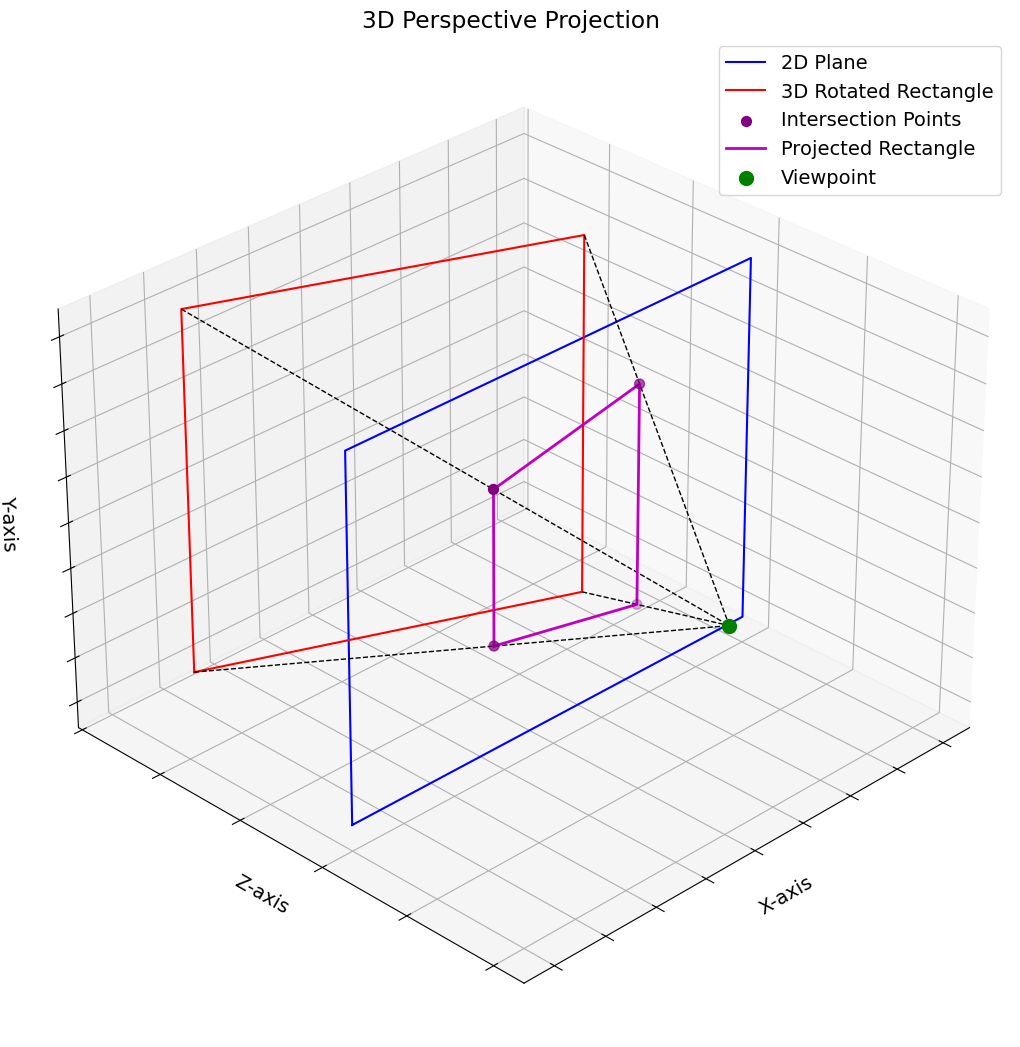

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_around_y(points, angle_deg):
    """Rotate points around the Y-axis by a given angle in degrees."""
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    rotation_matrix = np.array([
        [cos_a, 0, sin_a],
        [0,     1, 0    ],
        [-sin_a, 0, cos_a]
    ])
    return points @ rotation_matrix.T

def intersect_line_with_plane(p1, p2, plane_z=0):
    """Find the intersection of a line from p1 to p2 with the plane z=plane_z."""
    t = (plane_z - p1[2]) / (p2[2] - p1[2])
    intersection = p1 + t * (p2 - p1)
    return intersection

# Original rectangle in the xy-plane (z=0)
rectangle = np.array([
    [-1, -1, 0],  # Bottom-left
    [ 1, -1, 0],  # Bottom-right
    [ 1,  1, 0],  # Top-right
    [-1,  1, 0]   # Top-left
])

# Rotate the rectangle around the Y-axis by 45 degrees
rotated_rectangle = rotate_around_y(rectangle, angle_deg=45)

# Shift the rotated rectangle along the Z-axis
z_shift = 2
rotated_rectangle[:, 2] += z_shift

# Define the viewpoint (camera position)
viewpoint = np.array([0, 0, -2])

# Compute intersections with the z=0 plane
intersections = np.array([
    intersect_line_with_plane(rotated_rectangle[i], viewpoint)
    for i in range(len(rotated_rectangle))
])

# Visualization
fig = plt.figure(figsize=(16, 13))
ax = fig.add_subplot(111, projection='3d')

# Plot the original rectangle
original_rect_closed = np.vstack([rectangle, rectangle[0]])
ax.plot(
    original_rect_closed[:, 0],   # X-axis data
    original_rect_closed[:, 2],   # Y-axis data (use Z data)
    original_rect_closed[:, 1],   # Z-axis data (use Y data)
    'b-', label='2D Plane'
)

# Plot the rotated rectangle
rotated_rect_closed = np.vstack([rotated_rectangle, rotated_rectangle[0]])
ax.plot(
    rotated_rect_closed[:, 0],
    rotated_rect_closed[:, 2],    # Y-axis data (use Z data)
    rotated_rect_closed[:, 1],    # Z-axis data (use Y data)
    'r-', label='3D Rotated Rectangle'
)

# Plot lines from the rotated rectangle to the viewpoint
for i in range(len(rotated_rectangle)):
    xs = [rotated_rectangle[i, 0], viewpoint[0]]
    ys = [rotated_rectangle[i, 2], viewpoint[2]]  # Swap Y and Z
    zs = [rotated_rectangle[i, 1], viewpoint[1]]  # Swap Y and Z
    ax.plot(xs, ys, zs, 'k--', linewidth=1)

# Plot the intersection points
ax.scatter(
    intersections[:, 0],
    intersections[:, 2],    # Y-axis data (use Z data)
    intersections[:, 1],    # Z-axis data (use Y data)
    color='purple', s=50, label='Intersection Points'
)

# Connect intersection points to form the projected rectangle
intersections_closed = np.vstack([intersections, intersections[0]])
ax.plot(
    intersections_closed[:, 0],
    intersections_closed[:, 2],    # Y-axis data (use Z data)
    intersections_closed[:, 1],    # Z-axis data (use Y data)
    'm-', linewidth=2, label='Projected Rectangle'
)

# Plot the viewpoint
ax.scatter(
    viewpoint[0],
    viewpoint[2],    # Y-axis data (use Z data)
    viewpoint[1],    # Z-axis data (use Y data)
    color='g', s=100, label='Viewpoint'
)

# Set labels and title
ax.set_title('3D Perspective Projection')
ax.set_xlabel('X-axis')
ax.set_ylabel('Z-axis')  # Reflects swapped axes in plotting
ax.set_zlabel('Y-axis')  # Reflects swapped axes in plotting
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.legend()

# Adjust the viewing angle
ax.view_init(elev=30, azim=-135)

# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def rotate_around_y(points, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    rotation_matrix = np.array([
        [cos_a, 0, sin_a],
        [0,     1, 0    ],
        [-sin_a, 0, cos_a]
    ])
    return points @ rotation_matrix.T

def intersect_line_with_plane(p1, p2, plane_z=0):
    t = (plane_z - p1[2]) / (p2[2] - p1[2])
    intersection = p1 + t * (p2 - p1)
    return intersection

# Original rectangle in the xy-plane (z=0)
rectangle = np.array([
    [-1, -1, 0],  # Bottom-left
    [ 1, -1, 0],  # Bottom-right
    [ 1,  1, 0],  # Top-right
    [-1,  1, 0]   # Top-left
])

# Define the plane (larger rectangle in the xy-plane)
plane = np.array([
    [-1.5, -2, 0],  # Bottom-left
    [ 1.5, -2, 0],  # Bottom-right
    [ 1.5,  2, 0],  # Top-right
    [-1.5,  2, 0]   # Top-left
])

# Rotate the rectangle around the Y-axis by 45 degrees
rotated_rectangle = rotate_around_y(rectangle, angle_deg=45)

# Shift the rotated rectangle along the Z-axis
z_shift = 2
rotated_rectangle[:, 2] += z_shift

# Define the viewpoint (camera position)
viewpoint = np.array([0, 0, -2])

# Compute intersections with the z=0 plane
intersections = np.array([
    intersect_line_with_plane(rotated_rectangle[i], viewpoint)
    for i in range(len(rotated_rectangle))
])

# Visualization
fig = plt.figure(figsize=(16, 13))
ax = fig.add_subplot(111, projection='3d')

# Plot the plane with bluish tint
plane_verts = [list(zip(plane[:, 0], plane[:, 2], plane[:, 1]))]  # Swap Y and Z axes
plane_collection = Poly3DCollection(plane_verts, color='lightblue', alpha=0.5)
ax.add_collection3d(plane_collection)

# Plot the original rectangle
original_rect_closed = np.vstack([rectangle, rectangle[0]])
ax.plot(
    original_rect_closed[:, 0],   # X-axis data
    original_rect_closed[:, 2],   # Y-axis data (use Z data)
    original_rect_closed[:, 1],   # Z-axis data (use Y data)
    'b-', linewidth=2, label='Original Rectangle'
)

# Plot the rotated rectangle
rotated_rect_closed = np.vstack([rotated_rectangle, rotated_rectangle[0]])
ax.plot(
    rotated_rect_closed[:, 0],
    rotated_rect_closed[:, 2],    # Y-axis data (use Z data)
    rotated_rect_closed[:, 1],    # Z-axis data (use Y data)
    'r-', linewidth=2, label='Rotated Rectangle'
)

# Plot lines from the rotated rectangle to the viewpoint
for i in range(len(rotated_rectangle)):
    xs = [rotated_rectangle[i, 0], viewpoint[0]]
    ys = [rotated_rectangle[i, 2], viewpoint[2]]  # Swap Y and Z
    zs = [rotated_rectangle[i, 1], viewpoint[1]]  # Swap Y and Z
    ax.plot(xs, ys, zs, 'k--', linewidth=1)

# Plot the intersection points
ax.scatter(
    intersections[:, 0],
    intersections[:, 2],    # Y-axis data (use Z data)
    intersections[:, 1],    # Z-axis data (use Y data)
    color='purple', s=50, label='Intersection Points'
)

# Connect intersection points to form the projected rectangle
intersections_closed = np.vstack([intersections, intersections[0]])
ax.plot(
    intersections_closed[:, 0],
    intersections_closed[:, 2],    # Y-axis data (use Z data)
    intersections_closed[:, 1],    # Z-axis data (use Y data)
    'm-', linewidth=2, label='Projected Rectangle'
)

# Plot the viewpoint
ax.scatter(
    viewpoint[0],
    viewpoint[2],    # Y-axis data (use Z data)
    viewpoint[1],    # Z-axis data (use Y data)
    color='g', s=100, label='Viewpoint'
)

# Set labels and title
ax.set_title('3D Perspective Projection')
ax.set_xlabel('X-axis')
ax.set_ylabel('Z-axis')  # Reflects swapped axes in plotting
ax.set_zlabel('Y-axis')  # Reflects swapped axes in plotting
ax.legend()

# Adjust the viewing angle
ax.view_init(elev=30, azim=-135)

# Adjust axis limits if necessary
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 3)
ax.set_zlim(-3, 3)

# Hide axis tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

# Display the plot
plt.show()

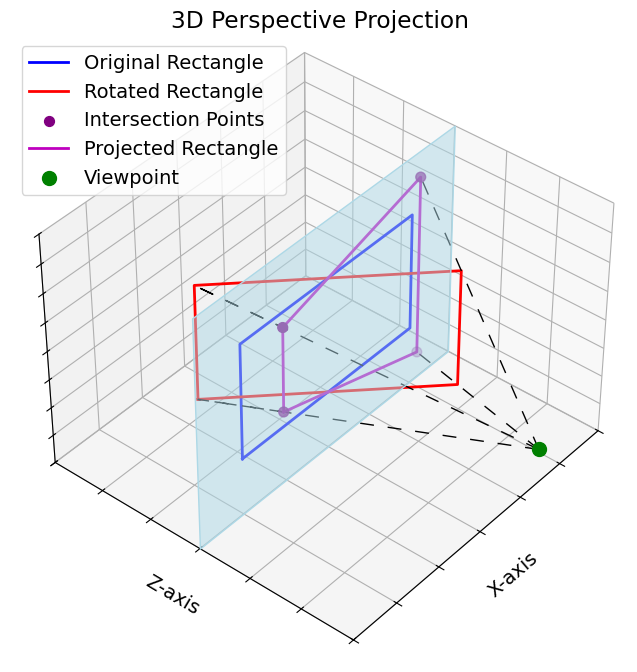

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def rotate_around_y(points, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    rotation_matrix = np.array([
        [cos_a, 0, sin_a],
        [0,     1, 0    ],
        [-sin_a, 0, cos_a]
    ])
    return points @ rotation_matrix.T

def intersect_line_with_plane(p1, p2, plane_z=0):
    t = (plane_z - p1[2]) / (p2[2] - p1[2])
    intersection = p1 + t * (p2 - p1)
    return intersection

# Original rectangle in the xy-plane (z=0)
rectangle = np.array([
    [-1, -1, 0],  # Bottom-left
    [ 1, -1, 0],  # Bottom-right
    [ 1,  1, 0],  # Top-right
    [-1,  1, 0]   # Top-left
])

# Define the plane (larger rectangle in the xy-plane)
plane = np.array([
    [-1.5, -2, 0],  # Bottom-left
    [ 1.5, -2, 0],  # Bottom-right
    [ 1.5,  2, 0],  # Top-right
    [-1.5,  2, 0]   # Top-left
])

# Rotate the rectangle around the Y-axis by 45 degrees
rotated_rectangle = rotate_around_y(rectangle, angle_deg=45)

# Define the viewpoint (camera position)
viewpoint = np.array([0, 0, -2])

# Compute intersections with the z=0 plane
intersections = np.array([
    intersect_line_with_plane(rotated_rectangle[i], viewpoint)
    for i in range(len(rotated_rectangle))
])

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the plane with bluish tint
plane_verts = [list(zip(plane[:, 0], plane[:, 2], plane[:, 1]))]  # Swap Y and Z axes
plane_collection = Poly3DCollection(plane_verts, color='lightblue', alpha=0.5)
ax.add_collection3d(plane_collection)

# Plot the original rectangle
original_rect_closed = np.vstack([rectangle, rectangle[0]])
ax.plot(
    original_rect_closed[:, 0],   # X-axis data
    original_rect_closed[:, 2],   # Y-axis data (use Z data)
    original_rect_closed[:, 1],   # Z-axis data (use Y data)
    'b-', linewidth=2, label='Original Rectangle'
)

# Plot the rotated rectangle
rotated_rect_closed = np.vstack([rotated_rectangle, rotated_rectangle[0]])
ax.plot(
    rotated_rect_closed[:, 0],
    rotated_rect_closed[:, 2],    # Y-axis data (use Z data)
    rotated_rect_closed[:, 1],    # Z-axis data (use Y data)
    'r-', linewidth=2, label='Rotated Rectangle'
)

# Plot dashed lines from the viewpoint through rotated rectangle to intersection points
for i in range(len(rotated_rectangle)):
    xs = [viewpoint[0], rotated_rectangle[i, 0], intersections[i, 0]]
    ys = [viewpoint[2], rotated_rectangle[i, 2], intersections[i, 2]]
    zs = [viewpoint[1], rotated_rectangle[i, 1], intersections[i, 1]]
    ax.plot(xs, ys, zs, 'k--', linewidth=1, dashes=[10, 10])

# Plot the intersection points
ax.scatter(
    intersections[:, 0],
    intersections[:, 2],    # Y-axis data (use Z data)
    intersections[:, 1],    # Z-axis data (use Y data)
    color='purple', s=50, label='Intersection Points'
)

# Connect intersection points to form the projected rectangle
intersections_closed = np.vstack([intersections, intersections[0]])
ax.plot(
    intersections_closed[:, 0],
    intersections_closed[:, 2],    # Y-axis data (use Z data)
    intersections_closed[:, 1],    # Z-axis data (use Y data)
    'm-', linewidth=2, label='Projected Rectangle'
)

# Plot the viewpoint
ax.scatter(
    viewpoint[0],
    viewpoint[2],    # Y-axis data (use Z data)
    viewpoint[1],    # Z-axis data (use Y data)
    color='g', s=100, label='Viewpoint'
)

# Set labels and title
ax.set_title('3D Perspective Projection')
ax.set_xlabel('X-axis')
ax.set_ylabel('Z-axis')  # Reflects swapped axes in plotting
ax.set_zlabel('Y-axis')  # Reflects swapped axes in plotting
ax.legend()

# Adjust the viewing angle
ax.view_init(elev=40, azim=-140)

# Adjust axis limits if necessary
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-2, 2)

# Hide axis tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

# Display the plot
plt.show()